# Deep learning on handwritten digits

The MNIST (mixed National Institute of Standards and Technology) dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database)) is a classic data set in machine learning. To develop our intuitions about the problem, we start with a simple linear classifier and achieve an average accuracy of $80\%$. We then proceed to build a state-of-the-art convolutional neural network (CNN) and achieve an accuracy of over $98\%$.

This notebook is available on [https://github.com/jcboyd/deep-learning-workshop](https://github.com/jcboyd/deep-learning-workshop).

A Docker image for this project is available on Docker hub:

> $ docker pull jcboyd/deep-learning-workshop/:[cpu|gpu]

> $ nvidia-docker run -it -p 8888:8888 jcboyd/deep-learning-workshop/:[cpu|gpu]

## 1. Machine Learning

* Machine learning involves algorithms that find patterns in data.


* This amounts to a form of *inductive reasoning*: inferring general rules from examples, with the view of reapplying them to new examples. *Learning by example*


* This symbols are labeled (yes/no) $\implies$ *supervised* learning problem


*Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012. (Figure 1.1)* 

![img/induction.png](img/induction.png)

* The corresponding dataset would look something like the following:

In [1]:
from pandas import read_csv
read_csv(open('data/data.csv'))

,Shape,Colour,Label
0,Arrow,Blue,Yes
1,Circle,Red,Yes
2,Star,Yellow,Yes
3,Triangle,Blue,Yes
4,Triangle,Yellow,Yes
5,Arrow,Orange,No
6,Circle,Blue,No
7,Circle,Green,No
8,Circle,Orange,No
9,Square,Orange,No


### 1.1 Classifiers

* The above is an example of a *classification* problem. 


* Each *observation* $\mathbf{x}$ is represented by a vector of $D$ *features* and has label $y_i$ denoting its class (e.g. yes or no).


* Thus, our dataset of $N$ observations is,

$$\mathcal{D} = \{\mathbf{x}_i, y_i\}_{i=1}^N,$$
$$\mathbf{x}_i \in \mathbb{R}^D, y_i \in \{1, \dots, C\}$$


* The model will attempt to divide the feature space such that the classes are as separate as possible, creating a *decision boundary*.

![img/separation.png](img/separation.png)

### 1.2 Data Exploration

* The MNIST dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database)) is a classic dataset in machine learning.


* Derived from a dataset of handwritten characters ``crowdsourced'' from US high school students.


* It consists of 60,000 labelled images of handwritten digits 0-9, and a test set of a further 10,000 images.


* Notably used as a benchmark in the development of convolutional neural networks.

In [2]:
from src import data_utils

Xtr, Ytr, Xte, Yte = data_utils.get_all_data()

print 'Training data shape: ', Xtr.shape
print 'Training labels shape: ', Ytr.shape
print 'Test data shape: ', Xte.shape
print 'Test labels shape: ', Yte.shape

Training data shape:  (60000, 28, 28, 1)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28, 1)
Test labels shape:  (10000,)


* We can visualise our data samples with Python

Class: 5


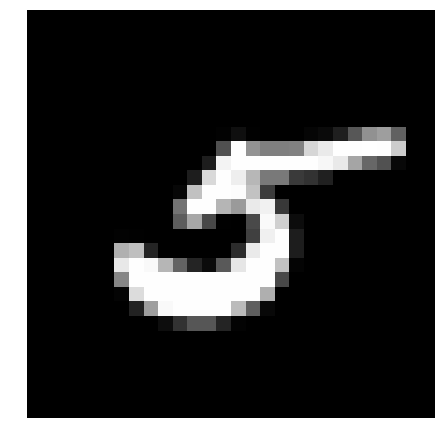

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from src import vis_utils

fig, ax = plt.subplots(figsize=(7.5, 7.5))
idx = np.random.randint(len(Xtr))
vis_utils.plot_image(ax, Xtr[idx][0:,:,0], Ytr[idx])

* As far as our model will be concerned, the images in the dataset are just vectors of numbers


* From this perspective, there is no structural difference between the MNIST problem, and the symbols problem above


* The observations just live in 784-dimensional space (28 x 28 pixels) rather than 2-dimensional space.

In [4]:
print Xtr[idx].reshape((1, 784))[0]

[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.

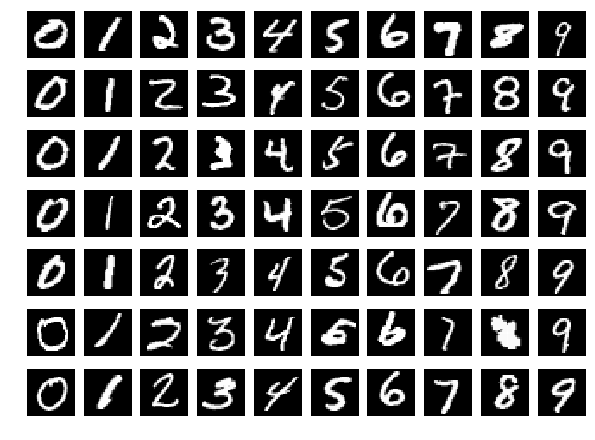

In [5]:
fig = plt.figure(figsize=(10, 7.5))
vis_utils.plot_array(fig, Xtr, Ytr)


### 1.3 Data Preprocessing

* To help with model assessment, we set aside some *validation* data from the training set

In [6]:
# First, vectorise image data
Xtr_rows = np.reshape(Xtr, (Xtr.shape[0], -1))
Xte_rows = np.reshape(Xte, (Xte.shape[0], -1))

# Subsample the data for more efficient code execution in this exercise.
num_training = 59000
num_validation = 1000
num_test = 10000

# Create validation split
Xtr_rows, Ytr, Xval_rows, Yval, Xte_rows, Yte = data_utils.create_data_splits(
    Xtr_rows, Ytr, Xte_rows, Yte, num_training, num_validation, num_test)

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', Xtr_rows.shape
print 'Validation data shape: ', Xval_rows.shape
print 'Test data shape: ', Xte_rows.shape

Training data shape:  (59000, 784)
Validation data shape:  (1000, 784)
Test data shape:  (10000, 784)


* A typical procedure prior to training is to normalise the data.


* Here we subtract the *mean image*

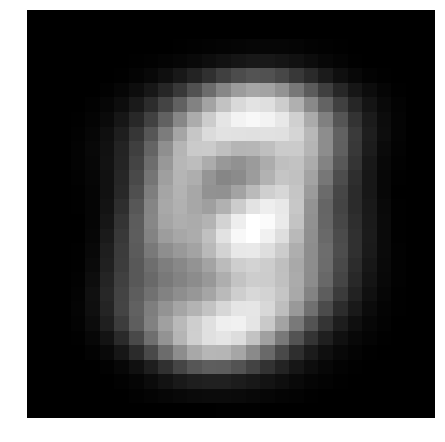

In [7]:
mean_image = np.mean(Xtr, axis=0).reshape(1, 784)

Xtr_rows -= mean_image
Xval_rows -= mean_image
Xte_rows -= mean_image

fig, ax = plt.subplots(figsize=(7.5, 7.5))
vis_utils.plot_image(ax, mean_image.reshape(28, 28))

### 1.2 Linear Classification

* First we will assume a linear *score function*, that is, a prediction that is a linear combination of inputs and model *weights*,

$$f(\mathbf{x} ; \mathbf{w}) = \mathbf{w}^T\mathbf{x} = w_1x_1 + w_2x_2 + \dots + w_Dx_D$$


* For MNIST, $D = 784$, and we need a weight for every pixel in an image.


* The choice of model weights will be *inferred* from the data in a procedure called *training*.


*Stanford Computer Vision course--Convolutional Neural Networks for Visual Recognition [http://cs231n.stanford.edu/](http://cs231n.stanford.edu/) *

<div style="text-align:center"><img src ="img/linear.png"/></div>

### 1.3 Model training

* Training involves computing a mathematical function that differentiates between observations from different classes--classifier.


* We first decide on a form for the function $f$ to take, then we optimise its parameters $\mathbf{w}$ over the dataset and a loss function, $\mathcal{L}$,

$$\mathbf{w}^* = \min_{\mathbf{w}} \sum_{i=1}^N \mathcal{L}(f(\mathbf{x}_i ; \mathbf{w}), y_i)$$


* The loss function measures how close the classification $f(\mathbf{x}_i ; \mathbf{w})$ of observations $\mathbf{x}_i$ is to the true value $y_i$.


* Training consists of finding the weights that minimise the loss over the training set.

* The most common procedure for optimising a convex differentiable function is known as *gradient descent*,

$$\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \alpha\nabla\mathcal{L}(\mathbf{w}^{(k)})$$

where $\alpha$ is referred to as the step size or *learning rate*. Thus, each iteration is a descent step, and we converge iteratively to a global minimum.

![img/gradientdescent.png](img/gradientdescent.png)

In [8]:
from src.linear_models import MultiSVM, SoftmaxRegression

# Perform bias trick
Xtr_rows = np.append(Xtr_rows, np.ones((Xtr_rows.shape[0], 1)), axis=1)
Xval_rows = np.append(Xval_rows, np.ones((Xval_rows.shape[0], 1)), axis=1)
Xte_rows = np.append(Xte_rows, np.ones((Xte_rows.shape[0], 1)), axis=1)

reg = 5e4
batch_size = 200
max_iters = 1500
learning_rate = 1e-7

model = MultiSVM(Xtr_rows, Ytr)
model.train(reg, batch_size, learning_rate, max_iters, Xval_rows, Yval)

Step 0 of 1500
Mini-batch loss: 73.03822 Learning rate: 0.00000
Validation error: 0.8720
Step 100 of 1500
Mini-batch loss: 32.49823 Learning rate: 0.00000
Validation error: 0.8530
Step 200 of 1500
Mini-batch loss: 17.62190 Learning rate: 0.00000
Validation error: 0.8290
Step 300 of 1500
Mini-batch loss: 12.16345 Learning rate: 0.00000
Validation error: 0.7820
Step 400 of 1500
Mini-batch loss: 10.15973 Learning rate: 0.00000
Validation error: 0.7100
Step 500 of 1500
Mini-batch loss: 9.42493 Learning rate: 0.00000
Validation error: 0.6030
Step 600 of 1500
Mini-batch loss: 9.15521 Learning rate: 0.00000
Validation error: 0.4740
Step 700 of 1500
Mini-batch loss: 9.05624 Learning rate: 0.00000
Validation error: 0.3500
Step 800 of 1500
Mini-batch loss: 9.02000 Learning rate: 0.00000
Validation error: 0.2590
Step 900 of 1500
Mini-batch loss: 9.00661 Learning rate: 0.00000
Validation error: 0.2230
Step 1000 of 1500
Mini-batch loss: 9.00178 Learning rate: 0.00000
Validation error: 0.1980
Step 1

### 1.4 Model Testing

In [9]:
num_test = Yte.shape[0]
predictions = [model.predict(Xte_rows[i]) for i in range(num_test)]
print 'Error: %.02f%%' % (100 * (1 - float(sum(Yte == np.array(predictions))) / num_test))

Error: 26.03%


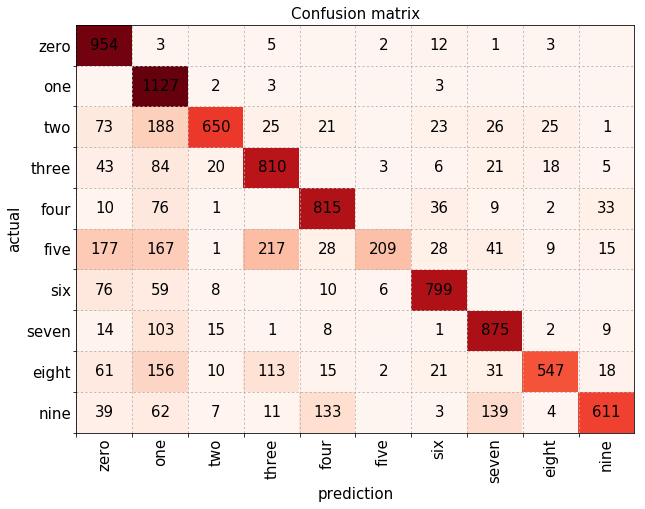

In [10]:
from src import vis_utils

num_classes = 10

fig, ax = plt.subplots(figsize=(10, 7.5))

classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
confusion_matrix = np.zeros((num_classes, num_classes), np.int32)

for i in range(len(predictions)):
    confusion_matrix[Yte[i]][predictions[i]] += 1

vis_utils.plot_confusion_matrix(ax, confusion_matrix, classes, fontsize=15)

* Let's look at some of the model's mistakes

Prediction: 0
True class: 6


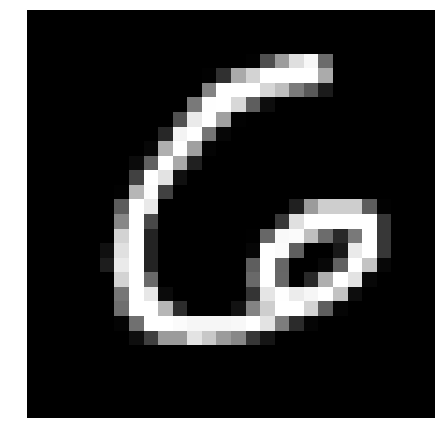

In [11]:
false = np.where(np.not_equal(Yte, predictions))[0]
idx = np.random.choice(false)
print 'Prediction: %d\nTrue class: %d' % (predictions[idx], Yte[idx])

fig, ax = plt.subplots(figsize=(7.5, 7.5))
vis_utils.plot_image(ax, Xte[idx][0:,:,0])

* In pixel-space, the model had moderate success in separating the image clusters.

![img/normals.png](img/normals.png)

* The optimised weights are those generalising maximally over each of the class observations


* We can take each of the weight vectors and plot them as an image to visualise the template they have learned

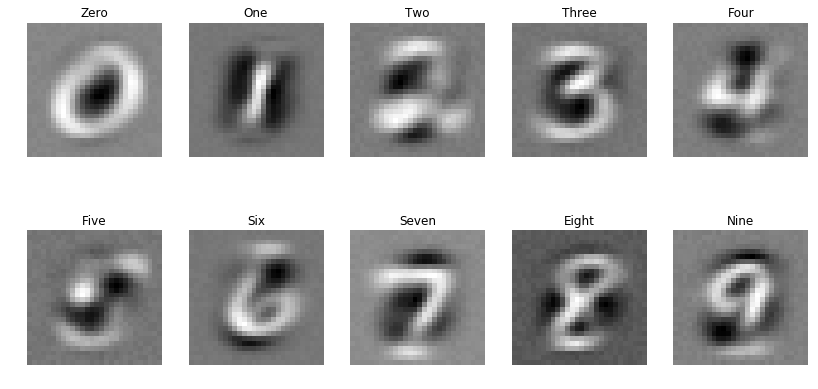

In [12]:
fig = plt.figure(figsize=(14, 7))
vis_utils.plot_weights(fig, weights = model.W[:-1,:])

## 2. Deep Learning

### 2.1 Features
* Features provide a *representation* of the objects we want to classify


* Designing features is arguably the most difficult and most important aspect of machine learning


* Previously we were operating purely on pixel features


* One way we might improve is with *feature engineering* (expert knowledge), *feature extraction*
(conventional techniques), *feature selection*, or *dimensionality reduction*.


* Another approach is to create non-linear transformations based on a *kernel function* (see kernel methods).

![img/convolve.png](img/convolve.png)

![img/convolution.jpg](img/convolution.jpg)

* Another approach is to build the feature learning into the model itself. This is the essence of *representation* or *deep learning*.


* Deep learning is characterised by the modeling of a hierarchy of abstraction in the input data


* Each layer of a CNN models features as agglomerations of the features in the previous layer (edges to blobs, to anatomical units, to objects, etc.)


* Neural networks are particularly amenable hierarchical learning, as hidden layers are easily stacked.


* Have surmounted long-standing challenges in artificial intelligence (e.g. AlphaGo).

*LeCun, Yann, Yoshua Bengio, and Geoffrey Hinton. "Deep learning." Nature 521.7553 (2015): 436-444.*

*For a live demo of this, see the Deep Visualisation Toolbox (https://www.youtube.com/watch?v=AgkfIQ4IGaM)*

### 2.2 Artificial Neural Networks

* Neural networks hidden model layers between input and ouptut, passing through non-linear activation function.


* (Loosely) inspired by the interaction of neurons in the human brain.


* No longer a linear model, outputs are not linear combinations of inputs and model parameters.


* Pros (+): Greater flexibility (universal approximator), built-in feature extraction


* Cons (-): Harder to train (not convex), theory relatively underdeveloped

![img/layers.png](img/layers.png)

### 2.3 Convolutional Neural Networks

* Convolutional Neural Networks (CNN) are a type of feed-forward neural network wired so as to perform convolutions (image processing) on input data.


* As such, feature extraction is built into the classifier, an optimised wrt the same loss function. *Representation learning*.


* LeNet is the original network architecture of CNNs, introduced by Yann Lecun in the 90s.


* Covolutional layers (loosely) inspired by the human visual cortex


*LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.*

![img/lenet.png](img/lenet.png)

* CNNs were the breakout success in 2012 that won the ImageNet image classification challenge.


* *AlexNet* was a *deep* architecture with many convolutional layers.


* The result was quickly followed by a paradigm shift in computer vision research, supplanting tailored feature extraction and reinstating neural networks.

*Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.*

### 2.4 Tensor Flow



* Python machine learning framework developed by Google Brain (deep learning team)


* Originally proprietary, made open source (Apache 2.0) in late 2015


* Model is built into a *computational graph*


* *Tensors* (multi-dimensional arrays of data) *flow* through the computational graph

*CNN code adapted from demo code in the official TensorFlow Docker image*

![img/tensorflowlogo.png](img/tensorflowlogo.png)

In [13]:
from src.cnn import ConvolutionalNeuralNetwork

model = ConvolutionalNeuralNetwork()

Model variables initialised
Model architecture initialised
Computational graph initialised


* Visualise computational graph with TensorBoard

![img/graph.png](img/graph.png)

### 2.5 Model Training

In [14]:
# Use unflattened data
Xval = Xtr[num_training:,:]
Xtr = Xtr[:num_training,:]

model.train(Xtr, Ytr, Xval, Yval)

Step 0 of 2000
Mini-batch loss: 8.61911 Error: 90.00000 Learning rate: 0.01000
Validation error: 89.2%
Step 100 of 2000
Mini-batch loss: 3.87724 Error: 30.00000 Learning rate: 0.01000
Validation error: 11.3%
Step 200 of 2000
Mini-batch loss: 3.13602 Error: 0.00000 Learning rate: 0.01000
Validation error: 4.7%
Step 300 of 2000
Mini-batch loss: 3.13972 Error: 10.00000 Learning rate: 0.01000
Validation error: 3.2%
Step 400 of 2000
Mini-batch loss: 3.08162 Error: 0.00000 Learning rate: 0.01000
Validation error: 6.0%
Step 500 of 2000
Mini-batch loss: 3.11150 Error: 10.00000 Learning rate: 0.01000
Validation error: 8.0%
Step 600 of 2000
Mini-batch loss: 2.96377 Error: 0.00000 Learning rate: 0.01000
Validation error: 4.0%
Step 700 of 2000
Mini-batch loss: 3.35120 Error: 10.00000 Learning rate: 0.01000
Validation error: 3.3%
Step 800 of 2000
Mini-batch loss: 2.91734 Error: 0.00000 Learning rate: 0.01000
Validation error: 5.3%
Step 900 of 2000
Mini-batch loss: 2.98756 Error: 10.00000 Learning r

### 2.6 Model testing

In [15]:
predictions = model.test_model(Xte)
correct = np.sum(predictions == Yte)
total = predictions.shape[0]

print 'Test error: %.02f%%' % (100 * (1 - float(correct) / float(total)))

Test error: 2.12%


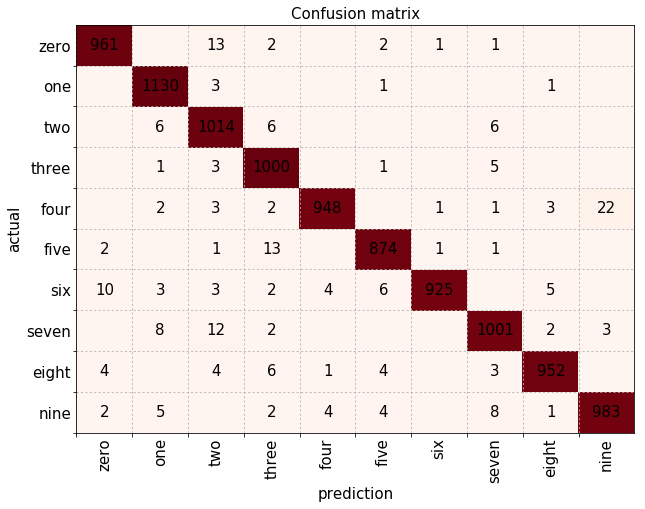

In [16]:
from src.vis_utils import plot_confusion_matrix

classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
confusion_matrix = np.zeros((num_classes, num_classes), np.int32)

for i in range(len(predictions)):
    confusion_matrix[Yte[i]][predictions[i]] += 1

fig, ax = plt.subplots(figsize=(10, 7.5))
plot_confusion_matrix(ax, confusion_matrix, classes, fontsize=15)

* Current world record: 0.21% error from *ensemble* of 5 CNNs with data augmentation

*Romanuke, Vadim. "Parallel Computing Center (Khmelnitskiy, Ukraine) represents an ensemble of 5 convolutional neural networks which performs on MNIST at 0.21 percent error rate.". Retrieved 24 November 2016."*


* We can plot the activation maps of the following image as it passes through the network

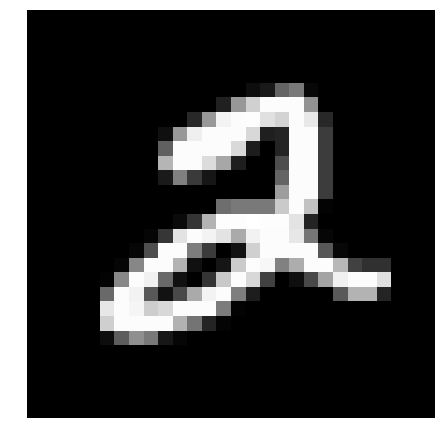

In [17]:
img = Xtr[5]
fig, ax = plt.subplots(figsize=(7.5, 7.5))
vis_utils.plot_image(ax, img[0:,:,0])

* First, the 32 activations of the first convolutional layer ($28 \times 28$ px)

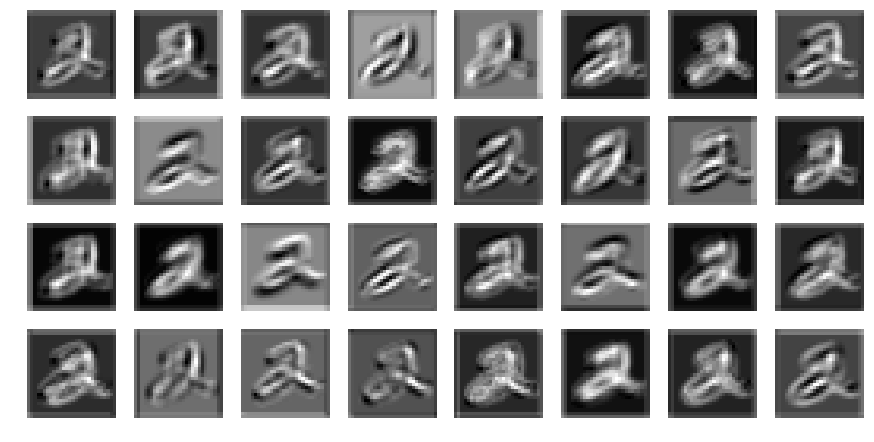

In [18]:
activation_maps = model.getActivations(model.conv1, img.reshape(1, 28, 28, 1))

fig = plt.figure(figsize=(15, 7.5))
vis_utils.plot_activation_maps(fig, activation_maps, 4, 8)
plt.show()

Then, the 64 activations of the second convolutional layer ($14 \times 14$ px)

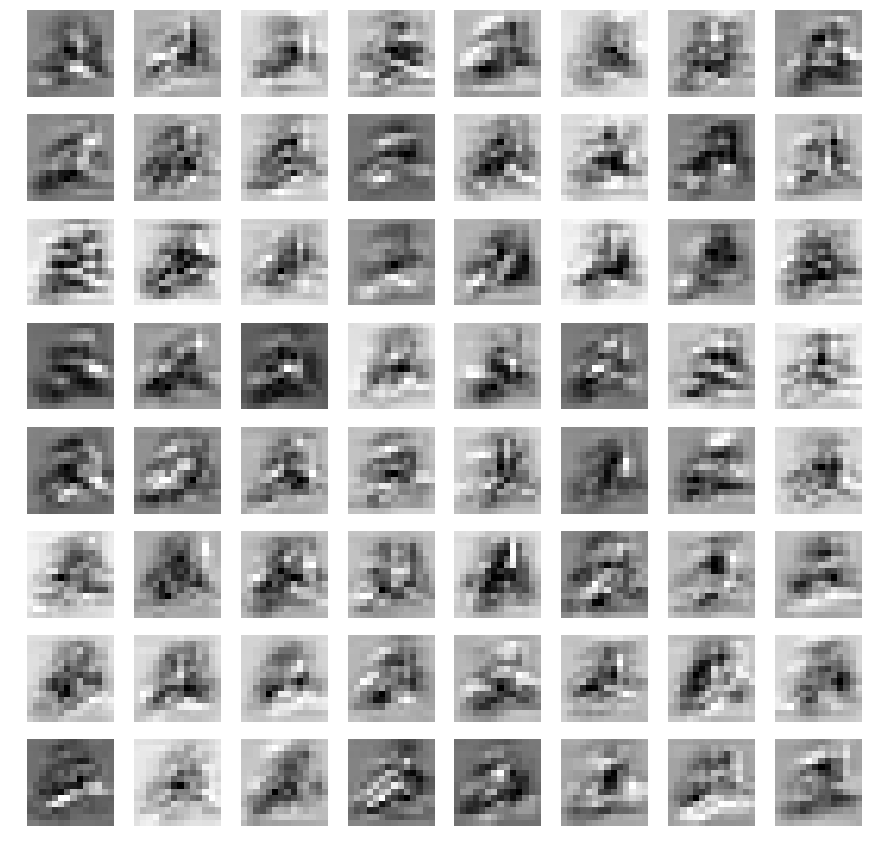

In [19]:
activation_maps = model.getActivations(model.conv2, img.reshape(1, 28, 28, 1))

fig = plt.figure(figsize=(15, 15))
vis_utils.plot_activation_maps(fig, activation_maps, 8, 8)
plt.show()